This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and a bunch of edits by Matthew Kehoe.

This notebook was generated for TensorFlow 2.6.

TODO: Previous material (summarize diagram, bag of words, and TextVectorization layer).

### Processing words as a sequence: The sequence model approach

These past few examples clearly show that <font color='blue'>word order matters</font>: manual engineering of order-based features, such as bigrams, yields a nice <font color='blue'>accuracy boost</font>. Now remember: the history of deep learning is that of a move away from manual feature engineering, toward letting models learn their own features from exposure to data alone. What if, instead of manually crafting order-based features, we exposed the model to raw word sequences and let it figure out such features on its own? This is what <font color='blue'>sequence models</font> are about.

To implement a sequence model, you'd start by representing your input samples as
<font color='blue'>sequences of integer indices</font> (one integer standing for one word). Then, you'd <font color='blue'>map each integer</font> to a <font color='blue'>vector</font> to obtain vector sequences. Finally, you'd feed these sequences of vectors into a stack of layers that could cross-correlate features from adjacent vectors, such as a 1D convnet, a RNN, or a Transformer.

For some time around 2016–2017, bidirectional RNNs (in particular, bidirectional
LSTMs) were considered to be the state of the art for sequence modeling. Since you're already familiar with this architecture, this is what we’ll use in our first sequence model examples. However, nowadays sequence modeling is almost universally done with Transformers, which we will cover shortly. Oddly, one-dimensional convnets were never very popular in NLP, even though, in my own experience, a residual stack of depthwise-separable 1D convolutions can often achieve comparable performance to a bidirectional LSTM, at a greatly reduced computational cost.

#### A first practical example

Let's try out a first sequence model in practice. First, let's prepare datasets that return <font color='blue'>integer</font> sequences.

**Downloading the data**

In [2]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  14.5M      0  0:00:05  0:00:05 --:--:-- 16.4M


TODO: Make some comments in code below.

**Preparing the data**

In [2]:
import os, pathlib, shutil, random
from tensorflow import keras
batch_size = 32
base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"
for category in ("neg", "pos"):
    os.makedirs(val_dir / category)
    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files)
    num_val_samples = int(0.2 * len(files))
    val_files = files[-num_val_samples:]
    for fname in val_files:
        shutil.move(train_dir / category / fname,
                    val_dir / category / fname)

train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size
)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size
)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)
text_only_train_ds = train_ds.map(lambda x, y: x)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


**Preparing integer sequence datasets**

In [3]:
from tensorflow.keras import layers

max_length = 600                                                                # In order to keep a manageable input size, we’ll truncate the
max_tokens = 20000                                                              # we’ll truncate the inputs after the first 600 words. This is
text_vectorization = layers.TextVectorization(                                  # a reasonable choice since the average review length is 233
    max_tokens=max_tokens,                                                      # words, and only 5% of reviews are longer than 600 words.
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

Next, let's make a model. A straightforward to convert our integer sequences to vector sequences is to <font color='blue'>one-hot encode</font> the integers (each dimension would represent one possible term in the vocabulary). On top of these one-hot vectors, we'll add a simple bidirectional LSTM.

**A sequence model built on one-hot encoded vector sequences**

In [4]:
import tensorflow as tf
inputs = keras.Input(shape=(None,), dtype="int64")                              # The input is a sequence of integers
embedded = tf.one_hot(inputs, depth=max_tokens)                                 # Encode the integers into binary 20,000-dimensional vectors.
x = layers.Bidirectional(layers.LSTM(32))(embedded)                             # Add a bidirectional LSTM
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)                              # Finally, add a classification layer
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 tf.one_hot (TFOpLambda)     (None, None, 20000)       0         
                                                                 
 bidirectional (Bidirectiona  (None, 64)               5128448   
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 5,128,513
Trainable params: 5,128,513
Non-trainable params: 0
___________________________________________________

Now, let's train our model.

**Training a first basic sequence model**

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm.keras",
                                    save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("one_hot_bidir_lstm.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/10
 66/625 [==>...........................] - ETA: 3:16:07 - loss: 0.6928 - accuracy: 0.5142

A first observation: this model trains <font color='blue'>very slowly</font>, especially compared to the light-weight model of the previous section. This is because our inputs are quite large: each input sample is encoded as a matrix of size `(600, 20000)` (600 words per sample, 20,000 possible words). That's 12,000,000 floats for a single movie review. Our bidirectional LSTM has a lot of work to do. Second, the model only gets to <font color='blue'>87%</font> test accuracy—it doesn't perform nearly as well as our (very fast) binary unigram model.
Clearly, using one-hot encoding to turn words into vectors, which was the simplest thing we could do, wasn't a great idea. There's a better way: *word embeddings*.

#### Understanding word embeddings

Crucially, when you encode something via one-hot encoding, you're making a feature-engineering decision. You're injecting into your model a fundamental <font color='blue'>assumption</font> about the structure of your feature space. That assumption is that the <font color='blue'>different tokens you're encoding are all independent from each other</font>: indeed, one-hot vectors are all orthogonal to one another. And in the case of <font color='blue'>words</font>, that assumption is clearly <font color='blue'>wrong</font>. Words form a structured space: they share information with each other. The words <font color='blue'>movie</font> and <font color='blue'>film</font> are interchangeable in most sentences, so the vector that represents “movie” should not be orthogonal to the vector that represents “film”—they should be the same vector, or close enough.

To get a bit more abstract, the <font color='blue'>geometric relationship</font> between two word vectors should reflect the <font color='blue'>semantic relationship</font> between these words. For instance, in a reasonable word vector space, you would expect synonyms to be embedded into similar word
vectors, and in general, you would expect the geometric distance (such as the cosine distance or L2 distance) between any two word vectors to relate to the “semantic distance” between the associated words. Words that mean <font color='blue'>different</font> things should <font color='blue'>lie far away</font> from each other, whereas <font color='blue'>related</font> words should be <font color='blue'>closer</font>.

<font color='blue'>Word embeddings</font> are vector representations of words that achieve exactly this: they map human language into a structured geometric space.

Whereas the vectors obtained through one-hot encoding are binary, sparse (mostly
made of zeros), and very high-dimensional (the same dimensionality as the number of words in the vocabulary), word embeddings are low-dimensional floating-point vectors (that is, dense vectors, as opposed to sparse vectors); see the figure below. It's common to see word embeddings that are 256-dimensional, 512-dimensional, or 1,024-dimensional when dealing with very large vocabularies. On the other hand, one-hot encoding words generally leads to vectors that are 20,000-dimensional or greater (capturing a vocabu-
lary of 20,000 tokens, in this case). So, <font color='blue'>word embeddings</font> pack more information into far <font color='blue'>fewer dimensions</font>.

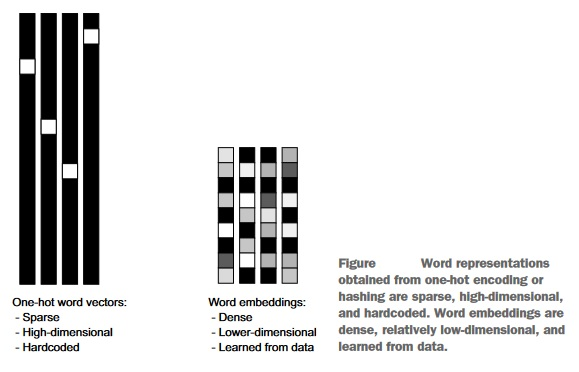

Besides being <font color='blue'>dense</font> representations, word embeddings are also <font color='blue'>structured</font> representations, and their structure is learned from data. Similar words get embedded in close locations, and further, specific <font color='blue'>directions</font> in the embedding space are meaningful. To make this clearer, let's look at a concrete example.

In the figure below, four words are embedded on a 2D plane: <font color='blue'>cat, dog, wolf</font>, and <font color='blue'>tiger</font>.
With the vector representations we chose here, some semantic relationships between these words can be encoded as geometric transformations. For instance, the same vector allows us to go from <font color='blue'>cat</font> to <font color='blue'>tiger</font> and from <font color='blue'>dog</font> to <font color='blue'>wolf</font>: this vector could be interpreted as the “from pet to wild animal” vector. Similarly, another vector lets us go from <font color='blue'>dog</font> to <font color='blue'>cat</font> and from <font color='blue'>wolf</font> to <font color='blue'>tiger</font>, which could be interpreted as a “from canine to feline” vector.

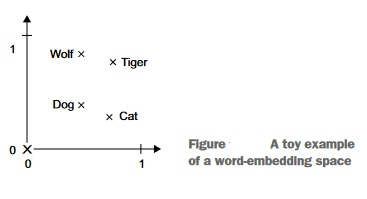

In real-world word-embedding spaces, common examples of meaningful geometric
transformations are “gender” vectors and “plural” vectors. For instance, by adding a <font color='blue'>female</font> vector to the vector <font color='blue'>king</font> , we obtain the vector <font color='blue'>queen</font>. By adding a <font color='blue'>plural</font>  vector, we obtain <font color='blue'>kings</font> . Word-embedding spaces typically feature thousands of such interpretable and potentially useful vectors.

Let's look at how to use such an embedding space in practice. There are two ways
to obtain word embeddings:

* Learn word embeddings jointly with the main task you care about (such as document classification or sentiment prediction). In this setup, you start with random word vectors and then learn word vectors in the same way you learn the
weights of a neural network.
* Load into your model word embeddings that were precomputed using a differ-
ent machine learning task than the one you're trying to solve. These are called
<font color='blue'>pretrained word embeddings</font>.

Let's review each of these approaches.

#### Learning word embeddings with the Embedding layer

Is there some ideal word-embedding space that would perfectly map human language
and could be used for any natural language processing task? Possibly, but we have yet to compute anything of the sort. Also, there is no such a thing as <font color='blue'>human language</font>—there are many different languages, and they aren't isomorphic to one another, because a language is the reflection of a specific culture and a specific context. But more pragmatically, what makes a good word-embedding space depends heavily on your task: the perfect word-embedding space for an English-language movie-review sentiment-analysis model may look different from the perfect embedding space for an English-language legal-document classification model, because the importance of certain semantic relationships varies from task to task.

It's thus reasonable to <font color='blue'>learn</font> a new embedding space with <font color='blue'>every new task</font>. Fortunately, backpropagation makes this easy, and Keras makes it even easier. It's about learning the weights of a layer: the <font color='blue'>Embedding</font> layer.

**Instantiating an `Embedding` layer**

In [1]:
embedding_layer = layers.Embedding(input_dim=max_tokens, output_dim=256)        # The Embedding layer takes at least two arguments: the number of
                                                                                # possible tokens and the dimensionality of the embeddings (here, 256).

NameError: ignored

The Embedding layer is best understood as a dictionary that maps integer indices
(which stand for specific words) to dense vectors. It takes integers as input, looks up these integers in an internal dictionary, and returns the associated vectors. It's effectively a dictionary lookup (see figure below).

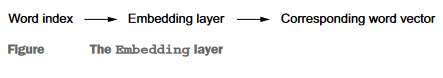

The *Embedding* layer takes as input a rank-2 tensor of integers, of shape `(batch_size,sequence_length)`, where each entry is a sequence of integers. The layer then returns a 3D floating-point tensor of shape `(batch_size, sequence_length, embedding_dimensionality)`.

When you instantiate an *Embedding* layer, its weights (its internal dictionary of token vectors) are initially random, just as with any other layer. During training, these word vectors are gradually adjusted via backpropagation, structuring the space into something the downstream model can exploit. Once fully trained, the embedding space will show a lot of structure—a kind of structure specialized for the specific problem for which you're training your model.

Let's build a model that includes an *Embedding* layer and benchmark it on our task.

**Model that uses an `Embedding` layer trained from scratch**

In [ ]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru.keras",
                                    save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("embeddings_bidir_gru.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

It trains much faster than the one-hot model (since the LSTM only has to process
256-dimensional vectors instead of 20,000-dimensional), and its test accuracy is comparable (<font color='blue'>87%</font>). However, we're still some way off from the results of our basic bigram model. Part of the reason why is simply that the model is looking at slightly less data: the <font color='blue'>bigram</font> model processed <font color='blue'>full reviews</font>, while our <font color='blue'>sequence</font> model <font color='blue'>truncates</font> sequences after <font color='blue'>600 words</font>.

#### Understanding padding and masking

One thing that's slightly hurting model performance here is that our input sequences are full of zeros. This comes from our use of the `output_sequence_length=max_length option` in `TextVectorization` (with `max_length` equal to 600): sentences longer than 600 tokens are truncated to a length of 600 tokens, and sentences shorter than 600 tokens are padded with zeros at the end so that they can be concatenated together with other sequences to form contiguous batches.

We're using a bidirectional RNN: two RNN layers running in parallel, with one
processing the tokens in their natural order, and the other processing the same
tokens in reverse. The RNN that looks at the tokens in their natural order will spend its last iterations seeing only vectors that encode padding—possibly for several hundreds of iterations if the original sentence was short. The information stored in the internal state of the RNN will gradually fade out as it gets exposed to these meaningless inputs.

We need some way to tell the RNN that it should skip these iterations. There's an API for that: <font color='blue'>masking<font color='blue'>.

The *Embedding* layer is capable of generating a “mask” that corresponds to its
input data. This mask is a tensor of ones and zeros (or True/False booleans), of shape `(batch_size, sequence_length)`, where the entry `mask[i, t]` indicates where time step `t` of sample `i` should be skipped or not (the timestep will be skipped if mask`[i, t]` is 0 or False, and processed otherwise).

By default, this option isn't active—you can turn it on by passing `mask_zero=True` to your *Embedding* layer. You can retrieve the mask with the `compute_mask()` method:

In [ ]:
embedding_layer = Embedding(input_dim=10, output_dim=256, mask_zero=True)
some_input = [
    [4, 3, 2, 1, 0, 0, 0],
    [5, 4, 3, 2, 1, 0, 0],
    [2, 1, 0, 0, 0, 0, 0]]
mask = embedding_layer.compute_mask(some_input)
<tf.Tensor: shape=(3, 7), dtype=bool, numpy=
array([[ True, True, True, True, False, False, False],
[ True, True, True, True, True, False, False],
[ True, True, False, False, False, False, False]])>

(FIX FROM HERE!)

In practice, you will almost never have to manage masks by hand. Instead, Keras will
automatically pass on the mask to every layer that is able to process it (as a piece of
metadata attached to the sequence it represents). This mask will be used by RNN lay-
ers to skip masked steps. If your model returns an entire sequence, the mask will also
be used by the loss function to skip masked steps in the output sequence.

**Using an `Embedding` layer with masking enabled**

In [ ]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(
    input_dim=max_tokens, output_dim=256, mask_zero=True)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru_with_masking.keras",
                                    save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("embeddings_bidir_gru_with_masking.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

#### Using pretrained word embeddings

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

**Parsing the GloVe word-embeddings file**

In [ ]:
import numpy as np
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

**Preparing the GloVe word-embeddings matrix**

In [ ]:
embedding_dim = 100

vocabulary = text_vectorization.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))

embedding_matrix = np.zeros((max_tokens, embedding_dim))
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

**Model that uses a pretrained Embedding layer**

In [ ]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("glove_embeddings_sequence_model.keras",
                                    save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("glove_embeddings_sequence_model.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")